In [1]:
import numpy as np
import gymnasium as gym
from noisyenv.wrappers import RandomNormalNoisyObservation
import matplotlib.pyplot as plt
# import gym
import d4rl



No module named 'flow'
/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/glfw/__init__.py:917: GLFWError: (65550) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
No module named 'carla'
pybullet build time: Jan 29 2025 23:19:57


In [2]:
base_env = gym.make("Hopper-v2")
env = RandomNormalNoisyObservation(env=base_env, noise_rate=1, loc = 0.0, scale=0.001)

/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/gymnasium/envs/registration.py:517: DeprecationWarning: WARN: The environment Hopper-v2 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(
/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/gymnasium/envs/mujoco/mujoco_py_env.py:223: DeprecationWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v5 or v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.deprecation(


In [10]:
# #load hopper-expert with qlearning_Dataset
# env = gym.make('halfcheetah-random-v0')
# dataset = d4rl.qlearning_dataset(env)


/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment halfcheetah-random-v0 is out of date. You should consider upgrading to version `v2` with the environment ID `halfcheetah-random-v2`.
  logger.warn(
/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/d4rl/gym_mujoco/gym_envs.py:18: UserWarning: This environment is deprecated. Please use the most recent version of this environment.
  offline_env.OfflineEnv.__init__(self, **kwargs)
/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/gym/spaces/box.py:78: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
load datafile:   0%|          | 0/5 [00:00<?, ?it/s]

load datafile: 100%|██████████| 5/5 [00:00<00:00,  7.72it/s]


In [11]:
dataset.keys()

dict_keys(['observations', 'actions', 'next_observations', 'rewards', 'terminals'])

In [55]:
observation, info = env.reset(seed=333)
observation_b, info_b = base_env.reset(seed=333)
noisy_data = {'observation': [], 'action': [], 'reward': [], 'next_observation': [], 'terminal': []}
data = {'observation': [], 'action': [], 'reward': [], 'next_observation': [], 'terminal': []}
for _ in range(100):
    action = env.action_space.sample()
    next_observation, reward, terminated, truncated, info = env.step(action)
    next_observation_b, reward_b, terminated_b, truncated_b, info_b = base_env.step(action)

    noisy_data['observation'].append(observation)
    noisy_data['action'].append(action)
    noisy_data['reward'].append([reward])
    noisy_data['next_observation'].append(next_observation)
    noisy_data['terminal'].append([terminated])

    data['observation'].append(observation_b)
    data['action'].append(action)
    data['reward'].append([reward_b])
    data['next_observation'].append(next_observation_b)
    data['terminal'].append([terminated_b])
    observation = next_observation
    observation_b = next_observation_b
    if terminated or truncated:
        observation, info = env.reset()
        observation_b, info_b = base_env.reset()
        # break #get one full episode only
    
noisy_data = {
            key: np.concatenate(noisy_data[key], axis=0)
            for key in noisy_data.keys()
        }
data = {
            key: np.concatenate(data[key], axis=0)
            for key in data.keys()
        }
noisy_data['next_observation'] = noisy_data['next_observation'].reshape(-1, next_observation_b.shape[0])
data['next_observation'] = data['next_observation'].reshape(-1, next_observation_b.shape[0])


noisy_data['observation'] = noisy_data['observation'].reshape(-1, observation_b.shape[0])
data['observation'] = data['observation'].reshape(-1, observation_b.shape[0])

noisy_data['action'] = noisy_data['action'].reshape(-1, action.shape[0])
data['action'] = data['action'].reshape(-1, action.shape[0])

env.close()
base_env.close()

In [56]:
next_observation_b.shape

(11,)

In [57]:
def plot_features(data_noisy, data, title = ''):
    #plot histograms of all features in data
    num_features = data.shape[1]
    num_rows = int(np.ceil(num_features / 3))
    fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 3))
    axs = axs.flatten()
    for i in range(num_features):
        # axs[i].hist(data_noisy[:, i], bins=100, alpha=0.7, color='orange', label ="noisy")
        # axs[i].hist(data[:, i], bins=100, alpha=0.7, color='blue', label = "no noise")
        
        axs[i].hist(data_noisy[:, i], bins=100, alpha=0.7, color='orange', label ="sate")
        axs[i].hist(data[:, i], bins=100, alpha=0.7, color='blue', label = "next state")
        
        axs[i].set_title(f'Feature {i}')
        axs[i].set_xlabel('Value')
        axs[i].set_ylabel('Frequency')
        axs[i].legend()
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

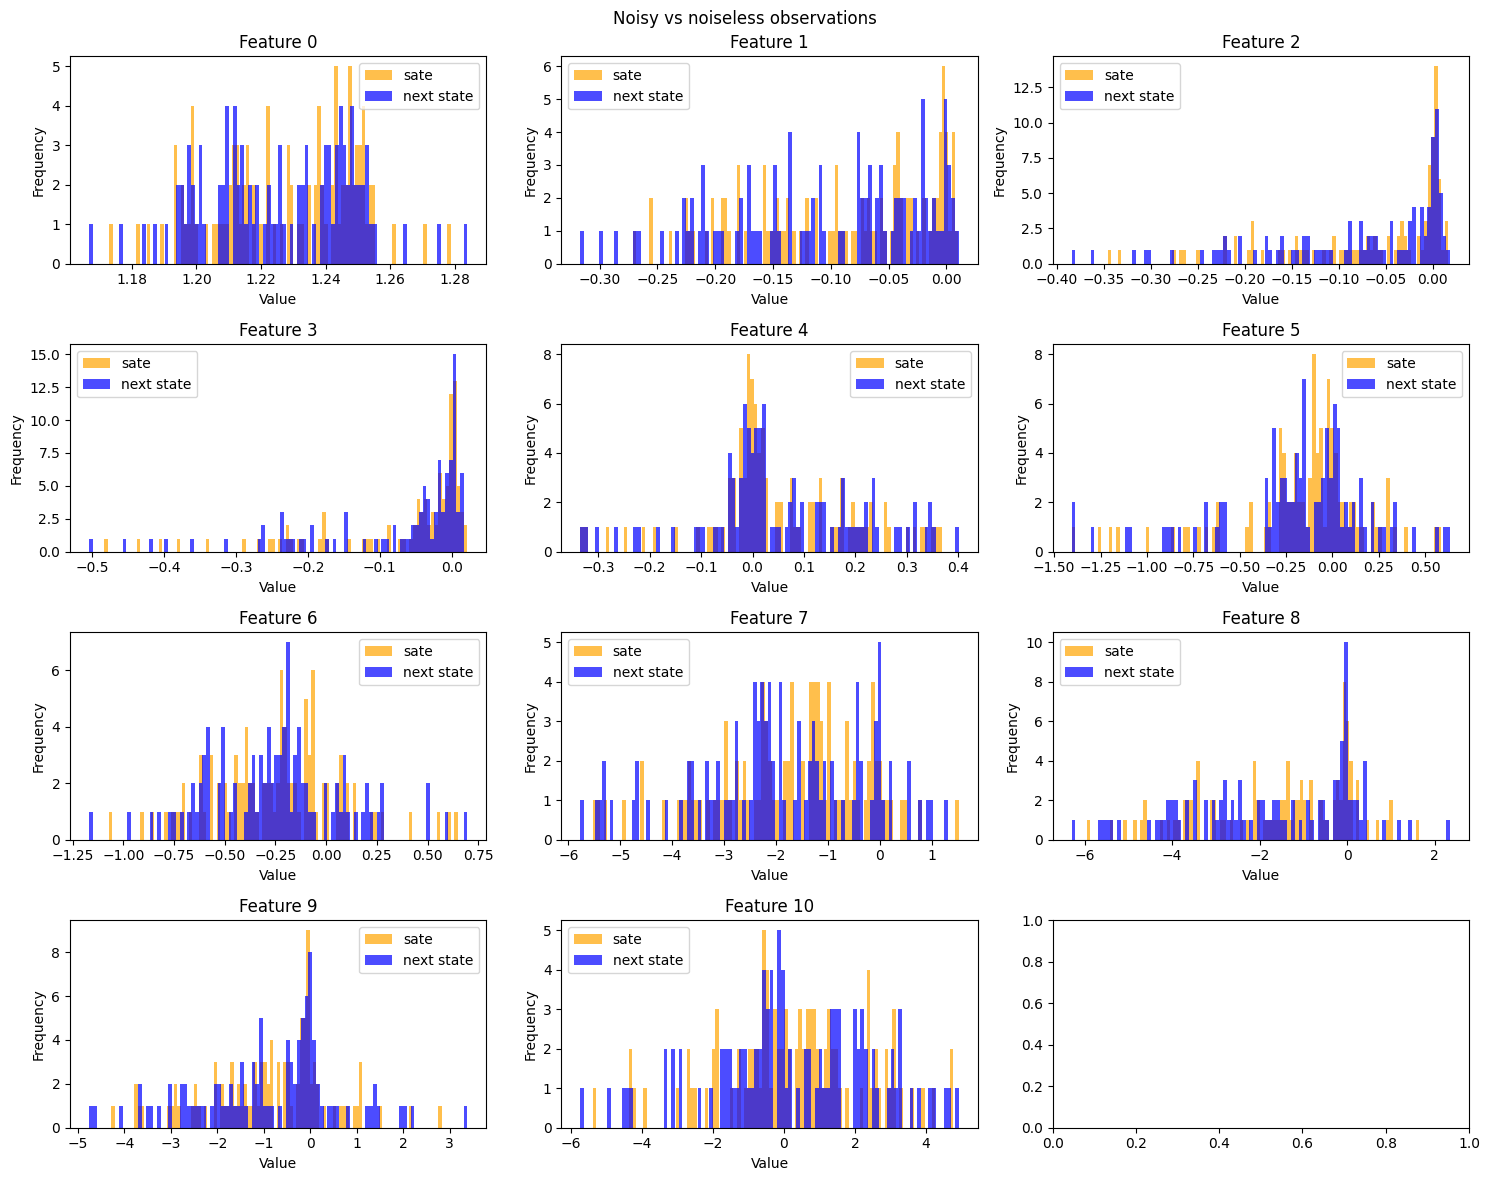

In [58]:
#plot data and noisy data observations
plot_features(noisy_data['observation'], data['observation'], title = 'Noisy vs noiseless observations')

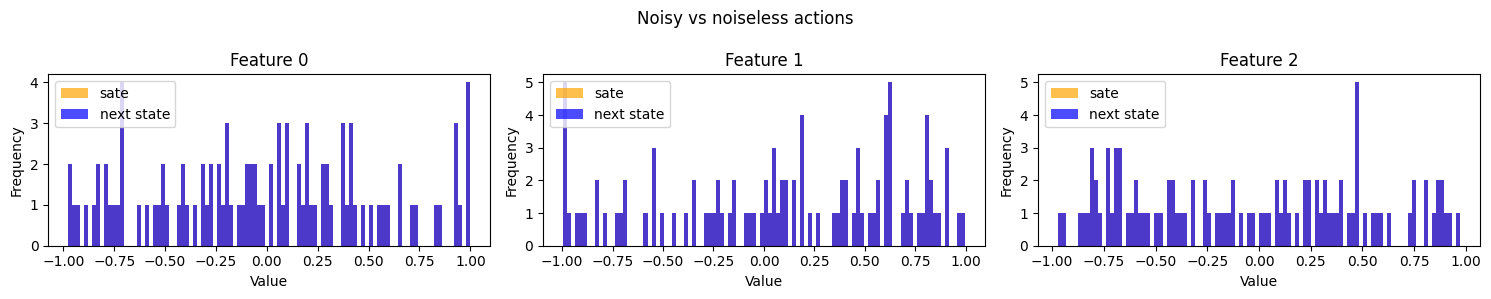

In [59]:
plot_features(noisy_data['action'], data['action'], title = 'Noisy vs noiseless actions')

In [60]:
class RandomNormalNoisyActions(gym.ActionWrapper):
    """Adds random Normal noise to the observations of the environment.

    Example:
        >>> import gymnasium as gym
        >>> from noisyenv.wrappers import RandomNormalNoisyObservation
        >>> env = gym.make("CartPole-v1")
        >>> wrapped_env = RandomNormalNoisyObservation(env, noise_rate=0.1, loc=0.0, scale=0.1)
    """

    def __init__(self, env, noise_rate=0.01, loc=0.0, scale=0.01):
        """Initializes the :class:`RandomNormalNoisyObservation` wrapper.

        Args:
            env (gym.Env): The environment to apply the wrapper
            noise_rate (float, optional): Probability of adding noise to the observation each step.
                Defaults to 0.01.
            loc (float, optional): Mean ("centre") of the noise distribution.
                Defaults to 0.0.
            scale (float, optional): Standard deviation (spread or "width") of the noise distribution.
                Must be non-negative. Defaults to 0.01.
        """
        super().__init__(env)
        self.noise_rate = noise_rate
        self.loc = loc
        self.scale = scale

    def action(self, action):
        """Modify the action by adding noise with some probability."""
        if np.random.rand() <= self.noise_rate:
            noise = np.random.normal(loc=self.loc, scale=self.scale, size=action.shape)
            action = action + noise
            # Clip to ensure action remains valid
            action = np.clip(action, self.env.action_space.low, self.env.action_space.high)
        return action

In [61]:

env_act = RandomNormalNoisyActions(env=base_env, noise_rate=1, loc = 0.0, scale=0.001)
observation, info = env_act.reset(seed=333)
observation_b, info_b = base_env.reset(seed=333)
noisy_data = {'observation': [], 'action': [], 'reward': [], 'next_observation': [], 'terminal': []}
data = {'observation': [], 'action': [], 'reward': [], 'next_observation': [], 'terminal': []}
for _ in range(100):

    #when SAC comes, sample from the policy
    action = env_act.action_space.sample()
    action_b = base_env.action_space.sample()
    next_observation, reward, terminated, truncated, info = env_act.step(action)
    next_observation_b, reward_b, terminated_b, truncated_b, info_b = base_env.step(action_b)

    noisy_data['observation'].append(observation)
    noisy_data['action'].append(action)
    noisy_data['reward'].append([reward])
    noisy_data['next_observation'].append(next_observation)
    noisy_data['terminal'].append([terminated])

    data['observation'].append(observation_b)
    data['action'].append(action_b)
    data['reward'].append([reward_b])
    data['next_observation'].append(next_observation_b)
    data['terminal'].append([terminated_b])
    observation = next_observation
    observation_b = next_observation_b
    if terminated or truncated:
        observation, info = env.reset()
        observation_b, info_b = base_env.reset()
        # break #get one full episode only
    
noisy_data = {
            key: np.concatenate(noisy_data[key], axis=0)
            for key in noisy_data.keys()
        }
data = {
            key: np.concatenate(data[key], axis=0)
            for key in data.keys()
        }
noisy_data['next_observation'] = noisy_data['next_observation'].reshape(-1, next_observation_b.shape[0])
data['next_observation'] = data['next_observation'].reshape(-1, next_observation_b.shape[0])

noisy_data['observation'] = noisy_data['observation'].reshape(-1, observation_b.shape[0])
data['observation'] = data['observation'].reshape(-1, observation_b.shape[0])

noisy_data['action'] = noisy_data['action'].reshape(-1, action.shape[0])
data['action'] = data['action'].reshape(-1, action.shape[0])

env.close()
base_env.close()

In [67]:
noisy_data['terminal'].shape

(100,)

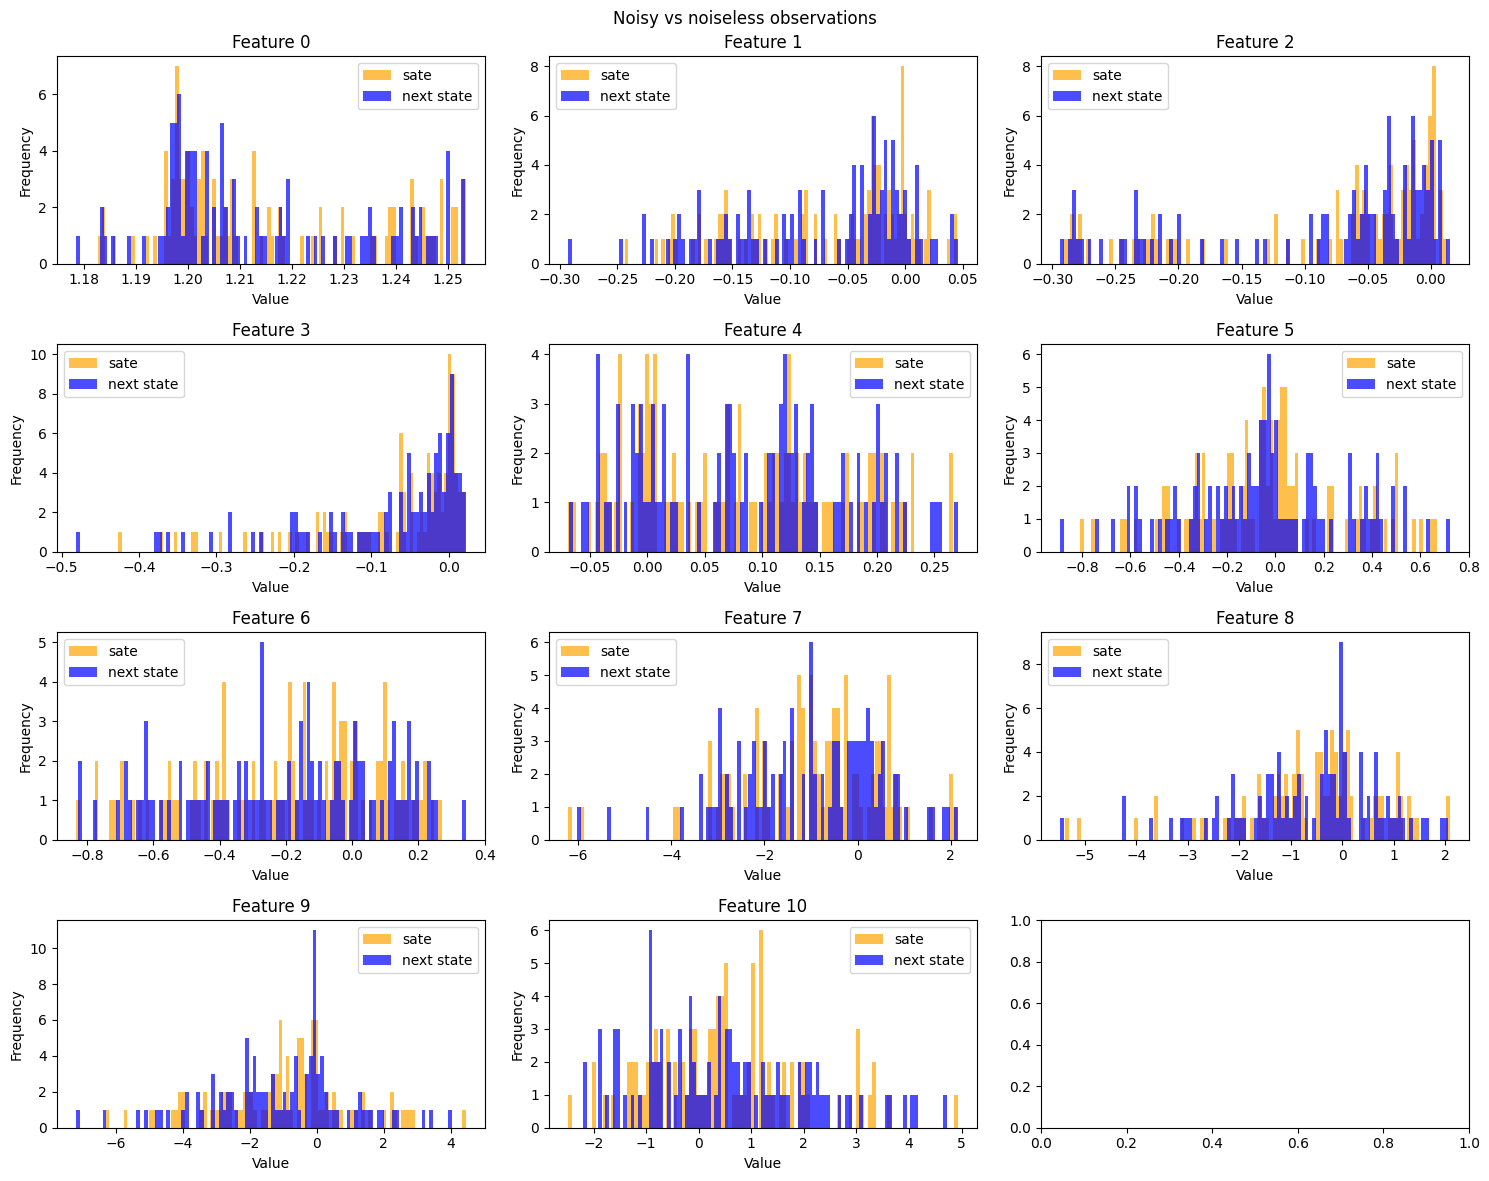

In [62]:
plot_features(noisy_data['observation'], data['observation'], title = 'Noisy vs noiseless observations')

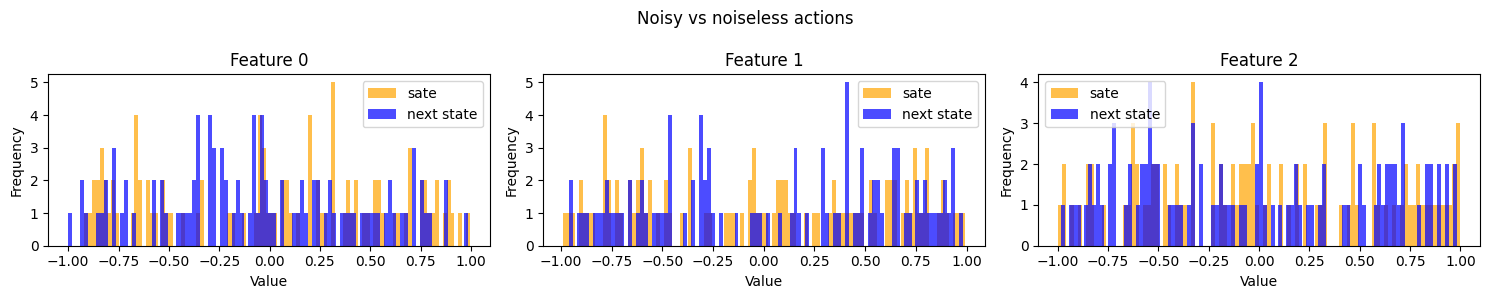

In [63]:
plot_features(noisy_data['action'], data['action'], title = 'Noisy vs noiseless actions')